In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#בדיקה לשימוש בgpu או cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

Working on: cpu


In [2]:
# הגדרת הטרנספורמציות
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("Loading Fashion-MNIST data.")
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print("Data loaded successfully.")

Loading Fashion-MNIST data.
Data loaded successfully.


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# יצירת המופע של הרשת והעברה ל-GPU
net = Net().to(device)
print("Model initialized.")

Model initialized.


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Starting Training...")
train_losses = []
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # שמירת ה-Loss הממוצע לאפוק הזה
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Starting Training...
Epoch 1, Loss: 0.5275
Epoch 2, Loss: 0.3538
Epoch 3, Loss: 0.3077
Epoch 4, Loss: 0.2831
Epoch 5, Loss: 0.2654
Epoch 6, Loss: 0.2540
Epoch 7, Loss: 0.2398
Epoch 8, Loss: 0.2329
Epoch 9, Loss: 0.2241
Epoch 10, Loss: 0.2154


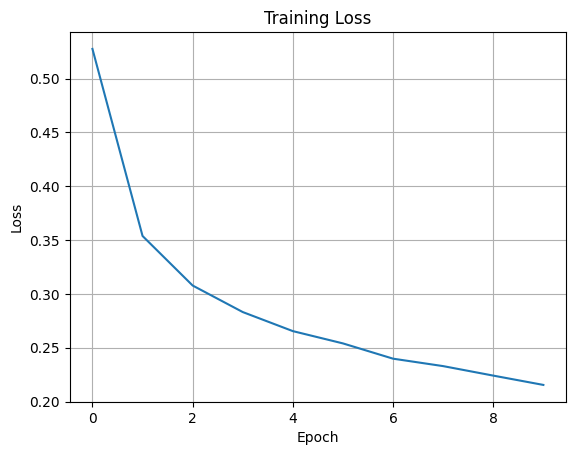

Accuracy on test set: 92.13%
Visualizing Filters (Layer 1):


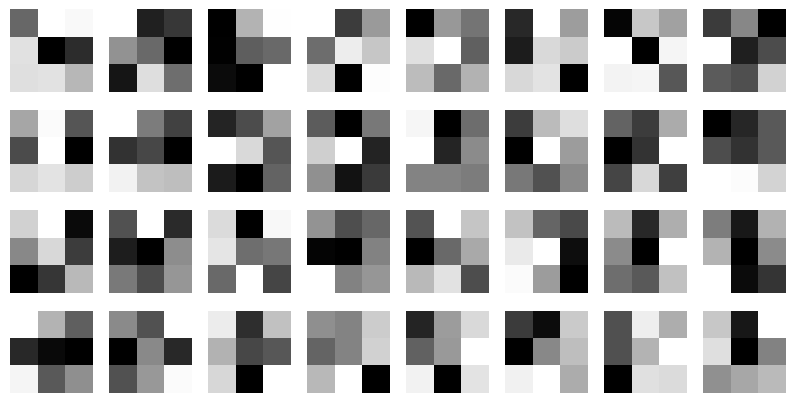

In [5]:
plt.figure()
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#  בדיקת דיוק על ה-Test Set
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')
print("Visualizing Filters (Layer 1):")
filters = net.conv1.weight.data.cpu()
fig = plt.figure(figsize=(10, 5))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1)
    ax.imshow(filters[i, 0, :, :], cmap='gray')
    ax.axis('off')
plt.show()